In [7]:
import numpy as np
import scipy as sp
import cvxpy as cvx

import timeit
import sys
from IPython.display import clear_output

N = 100 # Number of repetition
k = 100
d = 400

s_range = np.arange(1, 51, dtype="int32") # range of s

In [8]:
A = np.random.randn(k, d, N)

err = np.zeros([len(s_range), N], dtype="float64") # The relative error for l1-minimization
err_nn = np.zeros([len(s_range), N], dtype="float64") # The relative error for non-neg l1-minimization

for idx, s in enumerate(s_range):
    X = np.random.randn(s, N)
    err_tmp = np.zeros(N, dtype="float64")
    for n in range(N):
        S = np.random.choice(d, s, replace = False) # Uniformly choose the locations of non-zero elements
        
        x = np.zeros(d, dtype="float64")
        x[S] = X[:, n]
        y = np.dot(A[:, :, n], x)
        z = cvx.Variable(d)
        prob = cvx.Problem(cvx.Minimize(cvx.norm(z, 1)), [A[:, :, n] * z == y,])
        prob.solve()
        err[idx, n] = (np.linalg.norm(z.value.flatten() - x) ** 2) / (np.linalg.norm(x) ** 2)
        
        x = np.zeros(d, dtype="float64")
        x[S] = np.absolute(X[:, n])
        y = np.dot(A[:, :, n], x)
        z = cvx.Variable(d)
        prob = cvx.Problem(cvx.Minimize(cvx.norm(z, 1)), [A[:, :, n] * z == y, z >= 0])
        prob.solve()
        err_nn[idx, n] = (np.linalg.norm(z.value.flatten() - x) ** 2) / (np.linalg.norm(x) ** 2)
        
    #process.stdout
    clear_output()
    print("s={0}, err={1}, err_nn={2}".format(s, err[idx, :].mean(), err_nn[idx, :].mean()))
    sys.stdout.flush()
    
err_mean = err.mean(axis = 1)
err_std = err.std(axis = 1)

err_nn_mean = err_nn.mean(axis = 1)
err_nn_std = err_nn.std(axis = 1)

threshold = 1e-10
idx_nz = np.where(err_mean > threshold)[0].min() # The first non-zero position
idx_nn_nz = np.where(err_nn_mean > threshold)[0].min()

print("l1-min starts to fail at s={0}, l1-non-neg-min starts to fail at s={1}"\
      .format(s_range[idx_nz], s_range[idx_nn_nz]))

s=50, err=0.36883651482828883, err_nn=0.15628658723082758
l1-min starts to fail at s=20, l1-non-neg-min starts to fail at s=27


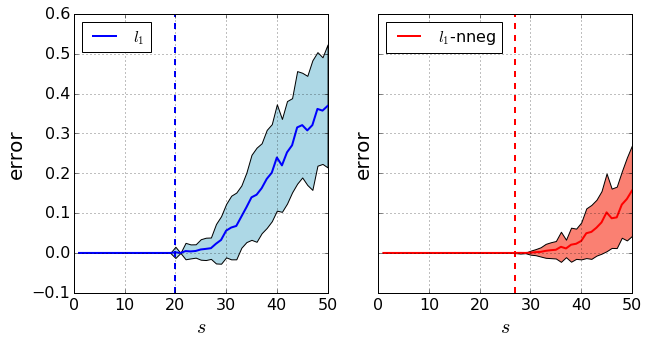

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

axis_font = {'size':'20'}
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))

axs[0].plot(s_range, err_mean, 'blue', linewidth=2, label="$l_1$")
axs[0].fill_between(s_range, err_mean-err_std, err_mean+err_std, facecolor='lightblue')
axs[0].axvline(s_range[idx_nz], color='blue', linestyle='--', linewidth=2)
axs[0].legend(prop={'size':16}, loc=2)
axs[0].grid()
axs[0].set_xlabel('$s$', **axis_font)
axs[0].set_ylabel('error', **axis_font)

axs[1].plot(s_range, err_nn_mean, 'red', linewidth=2, label="$l_1$-nneg")
axs[1].fill_between(s_range, err_nn_mean-err_nn_std, err_nn_mean+err_nn_std, facecolor='salmon')
axs[1].axvline(s_range[idx_nn_nz], color='red', linestyle='--', linewidth=2)
axs[1].legend(prop={'size':16}, loc=2)
axs[1].grid()
axs[1].set_xlabel('$s$', **axis_font)
axs[1].set_ylabel('error', **axis_font)

fig.savefig('error.pdf', dpi=10, bbox_inches='tight')